In [20]:
!pip install pandas numpy matplotlib seaborn scikit-learn prophet --quiet

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler
from scipy import stats
from prophet import Prophet
from IPython.display import display
from sklearn.metrics import mean_absolute_error



In [21]:
#https://docs.google.com/spreadsheets/d/1Pf9jnUMVbU62u7DtpZ4MWPyqR5I9aYm0tIpfedX9VpM/edit?gid=0#gid=0
# Use the correct Google Sheet ID and GID
sheet_id = "1Pf9jnUMVbU62u7DtpZ4MWPyqR5I9aYm0tIpfedX9VpM"
gid = "0"

# Convert to CSV export URL
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

df = pd.read_csv(url, header=None)

#Extract headers and data
headers = df.iloc[1]
unit_row = df.iloc[2]
scale_row = df.iloc[3]
data_rows = df.iloc[4:]


#Get index of Brinjal column
brinjal_col_index = headers[headers.str.contains("Vegetable-Dambulla-Wholesale-Brinjal", case=False, na=False)].index[0]


item_name = headers[brinjal_col_index]
unit = unit_row[brinjal_col_index]
scale = scale_row[brinjal_col_index]

# Extract Brinjal date and prices WITHOUT dropping missing values
brinjal_prices = data_rows[[0, brinjal_col_index]].copy()  # Make an explicit copy to avoid warnings

brinjal_prices.columns = ['Date', 'Price']

# Convert Date to string (safely)
brinjal_prices.loc[:, 'Date'] = brinjal_prices['Date'].astype(str)

# Create dictionary including missing prices
price_dict = dict(zip(brinjal_prices['Date'], brinjal_prices['Price']))

# Build final row and DataFrame
final_row = {'Item Name': item_name, 'Unit': unit, 'Scale': scale}
final_row.update(price_dict)

final_df = pd.DataFrame([final_row])

# Sort columns by date
fixed_columns = ['Item Name', 'Unit', 'Scale']
date_columns = sorted(
    [col for col in final_df.columns if col not in fixed_columns],
    key=lambda x: pd.to_datetime(x, dayfirst=True, errors='coerce')
)

final_df = final_df[fixed_columns + date_columns]

# Show table (with missing dates included)
from IPython.display import display
display(final_df)


,Item Name,Unit,Scale,1/6/2023,2/6/2023,3/6/2023,4/6/2023,5/6/2023,6/6/2023,7/6/2023,...,28/6/2025,29/6/2025,30/6/2025,1/7/2025,2/7/2025,3/7/2025,4/7/2025,5/7/2025,6/7/2025,7/7/2025
0,Vegetable-Dambulla-Wholesale-Brinjal,Rupees,Per Kg,290,325,NaN,NaN,275,275,175,...,NaN,NaN,290,400,325,340,375,NaN,NaN,NaN


In [22]:
df = final_df.copy()
display(df.head())  # Show initial df copy

,Item Name,Unit,Scale,1/6/2023,2/6/2023,3/6/2023,4/6/2023,5/6/2023,6/6/2023,7/6/2023,...,28/6/2025,29/6/2025,30/6/2025,1/7/2025,2/7/2025,3/7/2025,4/7/2025,5/7/2025,6/7/2025,7/7/2025
0,Vegetable-Dambulla-Wholesale-Brinjal,Rupees,Per Kg,290,325,NaN,NaN,275,275,175,...,NaN,NaN,290,400,325,340,375,NaN,NaN,NaN


In [23]:
# Normalize 'Item Name' column
df['Item Name'] = df['Item Name'].apply(lambda x: 'Brinjal' if 'brinjal' in x.lower() else x.capitalize())
display(df.head())  # After normalization

,Item Name,Unit,Scale,1/6/2023,2/6/2023,3/6/2023,4/6/2023,5/6/2023,6/6/2023,7/6/2023,...,28/6/2025,29/6/2025,30/6/2025,1/7/2025,2/7/2025,3/7/2025,4/7/2025,5/7/2025,6/7/2025,7/7/2025
0,Brinjal,Rupees,Per Kg,290,325,NaN,NaN,275,275,175,...,NaN,NaN,290,400,325,340,375,NaN,NaN,NaN


In [24]:
# Filter for brinjal only and make an explicit copy
brinjal = df[df['Item Name'] == 'Brinjal'].copy()
display(brinjal.head())  # After filtering

,Item Name,Unit,Scale,1/6/2023,2/6/2023,3/6/2023,4/6/2023,5/6/2023,6/6/2023,7/6/2023,...,28/6/2025,29/6/2025,30/6/2025,1/7/2025,2/7/2025,3/7/2025,4/7/2025,5/7/2025,6/7/2025,7/7/2025
0,Brinjal,Rupees,Per Kg,290,325,NaN,NaN,275,275,175,...,NaN,NaN,290,400,325,340,375,NaN,NaN,NaN


In [25]:
# Drop irrelevant columns
brinjal = brinjal.drop(['Item Name', 'Unit', 'Scale'], axis=1)
display(brinjal.head())  # After dropping cols


,1/6/2023,2/6/2023,3/6/2023,4/6/2023,5/6/2023,6/6/2023,7/6/2023,8/6/2023,9/6/2023,10/6/2023,...,28/6/2025,29/6/2025,30/6/2025,1/7/2025,2/7/2025,3/7/2025,4/7/2025,5/7/2025,6/7/2025,7/7/2025
0,290,325,NaN,NaN,275,275,175,190,165,NaN,...,NaN,NaN,290,400,325,340,375,NaN,NaN,NaN


In [26]:
# Transpose so dates become rows
brinjal = brinjal.T.reset_index()
brinjal.columns = ['ds', 'y']
display(brinjal.head())  # After transpose

,ds,y
0,1/6/2023,290
1,2/6/2023,325
2,3/6/2023,NaN
3,4/6/2023,NaN
4,5/6/2023,275


In [27]:
# Convert dates to datetime, coerce errors
brinjal['ds'] = pd.to_datetime(brinjal['ds'], dayfirst=True, errors='coerce')
display(brinjal.head())  # After datetime conversion

,ds,y
0,2023-06-01,290
1,2023-06-02,325
2,2023-06-03,NaN
3,2023-06-04,NaN
4,2023-06-05,275


In [28]:


# Drop rows where date conversion failed
brinjal = brinjal.dropna(subset=['ds'])
display(brinjal.head())  # After dropping NaT dates

,ds,y
0,2023-06-01,290
1,2023-06-02,325
2,2023-06-03,NaN
3,2023-06-04,NaN
4,2023-06-05,275


In [29]:
# Convert prices to numeric, coercing errors to NaN
brinjal['y'] = pd.to_numeric(brinjal['y'], errors='coerce')
display(brinjal.head())  # After price conversion

,ds,y
0,2023-06-01,290.0
1,2023-06-02,325.0
2,2023-06-03,NaN
3,2023-06-04,NaN
4,2023-06-05,275.0


In [30]:
# Interpolate missing price values
brinjal['y'] = brinjal['y'].interpolate(method='linear')
display(brinjal.head())  # After interpolation

,ds,y
0,2023-06-01,290.000000
1,2023-06-02,325.000000
2,2023-06-03,308.333333
3,2023-06-04,291.666667
4,2023-06-05,275.000000


In [31]:
# Drop any remaining NaN
brinjal = brinjal.dropna(subset=['y'])
display(brinjal.head())  # After dropping NaN prices


,ds,y
0,2023-06-01,290.000000
1,2023-06-02,325.000000
2,2023-06-03,308.333333
3,2023-06-04,291.666667
4,2023-06-05,275.000000


In [32]:
# Remove outliers using Z-score
z_scores = np.abs(stats.zscore(brinjal['y']))
brinjal = brinjal[(z_scores < 3)]
display(brinjal.head())  # After outlier removal

,ds,y
0,2023-06-01,290.000000
1,2023-06-02,325.000000
2,2023-06-03,308.333333
3,2023-06-04,291.666667
4,2023-06-05,275.000000


In [33]:
# Scale price values
scaler = MaxAbsScaler()
brinjal['y_scaled'] = scaler.fit_transform(brinjal[['y']])
display(brinjal.head())  # After scaling


,ds,y,y_scaled
0,2023-06-01,290.000000,0.504348
1,2023-06-02,325.000000,0.565217
2,2023-06-03,308.333333,0.536232
3,2023-06-04,291.666667,0.507246
4,2023-06-05,275.000000,0.478261


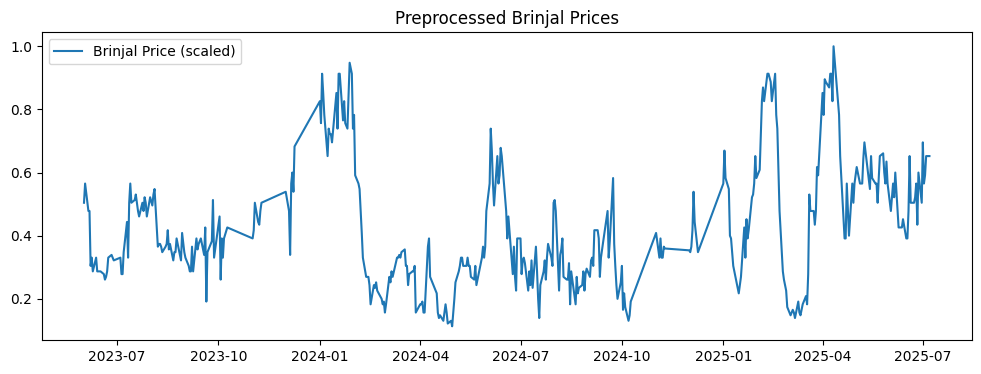

In [34]:
# Plot the preprocessed data
plt.figure(figsize=(12, 4))
plt.plot(brinjal['ds'], brinjal['y_scaled'], label='Brinjal Price (scaled)')
plt.title('Preprocessed Brinjal Prices')
plt.legend()
plt.show()


In [35]:
# Prepare dataframe for Prophet
prophet_df = brinjal[['ds', 'y_scaled']].rename(columns={'y_scaled': 'y'})
display(prophet_df.head())  # Before modeling

,ds,y
0,2023-06-01,0.504348
1,2023-06-02,0.565217
2,2023-06-03,0.536232
3,2023-06-04,0.507246
4,2023-06-05,0.478261


DEBUG:cmdstanpy:input tempfile: /tmp/tmp41eakj9u/9ec6qpsf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp41eakj9u/a2puyfld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88533', 'data', 'file=/tmp/tmp41eakj9u/9ec6qpsf.json', 'init=/tmp/tmp41eakj9u/a2puyfld.json', 'output', 'file=/tmp/tmp41eakj9u/prophet_modelanyxi1uv/prophet_model-20250712080311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:03:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:03:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


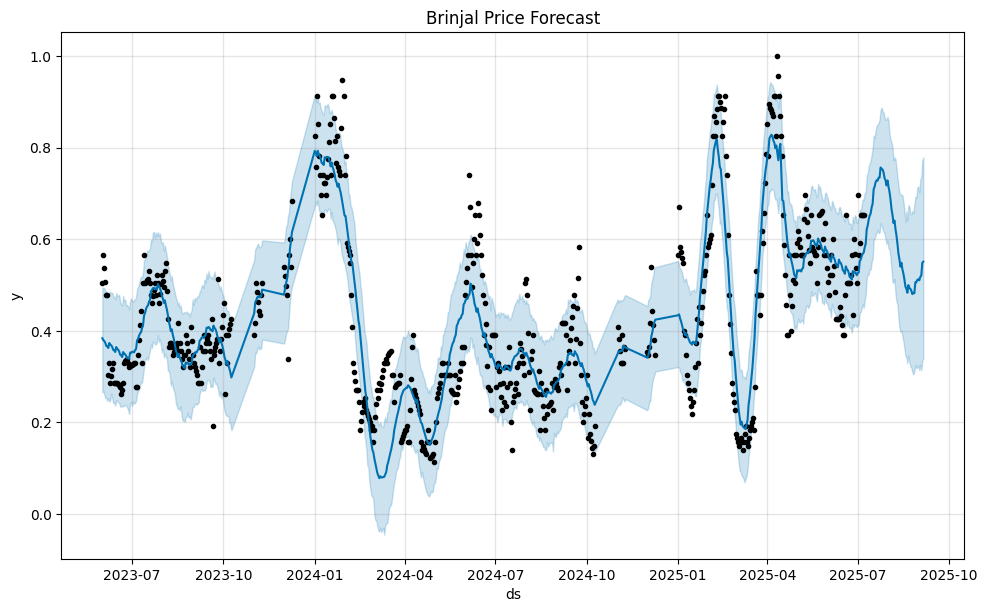

In [36]:
# Modeling
# Define custom holidays
holidays = pd.DataFrame({
    'holiday': ['new_year'] * 3,
    'ds': pd.to_datetime(['13/4/2024', '13/4/2025', '14/4/2025'], dayfirst=True),
    'lower_window': 0,
    'upper_window': 1
})


# Modeling with Prophet
model = Prophet(daily_seasonality=True, seasonality_mode='multiplicative',holidays=holidays)
model.fit(prophet_df)

# Forecasting
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Brinjal Price Forecast")
plt.show()

# Save model
with open('brinjal_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Also save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [37]:
# Inverse transform forecast
forecast['yhat_original'] = scaler.inverse_transform(forecast[['yhat']])
display(forecast[['ds', 'yhat_original']].tail(60))  # Show last 60 forecast rows

y_true = brinjal['y'].values
y_pred = forecast['yhat'][:len(y_true)].values


,ds,yhat_original
637,2025-07-08,334.705515
638,2025-07-09,339.261729
639,2025-07-10,357.210160
640,2025-07-11,362.051239
641,2025-07-12,369.431037
642,2025-07-13,374.442552
643,2025-07-14,377.265370
644,2025-07-15,384.889972
645,2025-07-16,389.733574
646,2025-07-17,407.364090


In [38]:

mae = mean_absolute_error(y_true, y_pred)

print("MAE:", mae)

MAE: 242.31921724125337
